<a href="https://colab.research.google.com/github/joshuaalpuerto/ML-guide/blob/main/Learning_TextGrad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qU textgrad --progress-bar off
!pip install -qU openai --progress-bar off

  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


In [3]:
# @title load fireworks API key
#connect to google drive
from google.colab import drive
import json
import os


drive.mount('/content/drive')

with open('/content/drive/MyDrive/env/env.json') as jsonfile:
    env = json.load(jsonfile)

os.environ['OPENAI_API_KEY'] = env['fireworks.ai']['apiKey']
os.environ['OPENAI_BASE_URL'] = "https://api.fireworks.ai/inference/v1"

Mounted at /content/drive


In [4]:
from openai import OpenAI

from textgrad.engine import get_engine
from textgrad import Variable
from textgrad.optimizer import TextualGradientDescent
from textgrad.loss import TextLoss
from textgrad.engine.openai import ChatOpenAI

engine = ChatOpenAI(model_string='accounts/fireworks/models/mixtral-8x7b-instruct')
eval_engine = ChatOpenAI(model_string='accounts/fireworks/models/mixtral-8x22b-instruct')

In [ ]:
x = Variable("A sntence with a typo", role_description="The input sentence", requires_grad=True)
engine.generate("Hello how are you?")

"Hello! I'm an artificial intelligence, so I don't have feelings, but I'm here and ready to assist you. How can I help you today?"

## Introduction: Loss

Again, Loss in TextGrad is the metaphorical equivalent of loss in PyTorch. We use Losses in different form in TextGrad but for now we will focus on a simple TextLoss. TextLoss is going to evaluate the loss wrt a string.

In [ ]:
system_prompt = Variable("Evaluate the correctness of this sentence", role_description="The system prompt")
loss = TextLoss(system_prompt, engine=engine)

## Introduction: Optimizer

Keeping on the analogy with PyTorch, the optimizer in TextGrad is the object that will update the parameters of the model. In this case, the parameters are the variables that have `requires_grad` set to `True`.

**NOTE** This is a text optimizer! It will do all operations with text!

In [ ]:
optimizer = TextualGradientDescent(parameters=[x], engine=engine)

## Putting it all together

We can now put all the pieces together. We have a variable, an engine, a loss, and an optimizer. We can now run a single optimization step.

In [ ]:
l = loss(x)
l.backward(engine)
optimizer.step()

INFO:textgrad:LLMCall function forward
INFO:textgrad:_backward_through_llm prompt
INFO:textgrad:_backward_through_llm gradient
INFO:textgrad:_backward_through_llm prompt
INFO:textgrad:_backward_through_llm gradient
INFO:textgrad:TextualGradientDescent prompt for update
INFO:textgrad:TextualGradientDescent optimizer response
INFO:textgrad:TextualGradientDescent updated text


In [ ]:
x.value

'A sentence with a typo'

# Solution optimization

From this [notebook](https://colab.research.google.com/github/zou-group/TextGrad/blob/main/examples/notebooks/Tutorial-Solution-Optimization.ipynb) the result from our model is not good compared gpt4o.

In [ ]:
import textgrad as tg

initial_solution = """To solve the equation 3x^2 - 7x + 2 = 0, we use the quadratic formula:
x = (-b ± √(b^2 - 4ac)) / 2a
a = 3, b = -7, c = 2
x = (7 ± √((-7)^2 + 4(3)(2))) / 6
x = (7 ± √73) / 6
The solutions are:
x1 = (7 + √73)
x2 = (7 - √73)"""

solution = tg.Variable(initial_solution,
                       requires_grad=True,
                       role_description="solution to the math question")

loss_system_prompt = tg.Variable("""You will evaluate a solution to a math question.
Do not attempt to solve it yourself, do not give a solution, only identify errors. Be super concise.""",
                                 requires_grad=False,
                                 role_description="system prompt")

loss_fn = tg.TextLoss(loss_system_prompt, engine=engine)
optimizer = tg.TGD(parameters=[solution], engine=eval_engine)

In [ ]:
loss = loss_fn(solution)
loss

INFO:textgrad:LLMCall function forward


Variable(value=The solutions are correct, but the expression for x1 is missing a multiplication sign. It should be:
x1 = (7 + √73) / 6
Otherwise, the solution is correct and there are no errors to point out., role=response from the language model, grads=)

In [ ]:
loss.backward(engine=eval_engine)
optimizer.step()
print(solution.value)

INFO:textgrad:_backward_through_llm prompt
INFO:textgrad:_backward_through_llm gradient
INFO:textgrad:TextualGradientDescent prompt for update
INFO:textgrad:TextualGradientDescent optimizer response
INFO:textgrad:TextualGradientDescent updated text


To solve the equation 3x^2 - 7x + 2 = 0, we use the quadratic formula:
x = (-b ± √(b^2 - 4ac)) / 2a
a = 3, b = -7, c = 2
x = (7 ± √((-7)^2 + 4(3)(2))) / 6
The solutions are:
x1 = (7 + √73) / 6
x2 = (7 - √73) / 6


In [5]:
# @title Another solution optimization example

import textgrad as tg


model = tg.BlackboxLLM(engine=engine)
question_string = ("If it takes 1 hour to dry 25 shirts under the sun, "
                   "how long will it take to dry 30 shirts under the sun? "
                   "Reason step by step")

question = tg.Variable(question_string,
                       role_description="question to the LLM",
                       requires_grad=False)

answer = model(question)
answer

INFO:textgrad:LLMCall function forward


Variable(value=Sure, I'd be happy to help you reason through this problem!

1. First, let's consider how long it takes to dry one shirt in the sun. From the information given, we know that 25 shirts take 1 hour to dry. So, if we divide the number of shirts by the time it takes to dry them, we can find out how long it takes to dry one shirt. That is, 25 shirts / 1 hour = 1 shirt per hour.

2. Now, if we want to dry 30 shirts, and it takes 1 hour to dry 1 shirt, then to find out how long it will take to dry 30 shirts, we simply multiply the number of shirts by the time it takes to dry one shirt. That is, 30 shirts * 1 hour per shirt = 30 hours.

However, this answer assumes that you can only dry one shirt at a time, which may not be the case. If you have space to lay out all 30 shirts at once, then the drying time would still be 1 hour, just like it was for 25 shirts. The drying time depends on the rate of drying (which seems to be about 25 shirts per hour in this case), not the total am

In [8]:
answer.set_role_description("concise and accurate answer to the question")

optimizer = tg.TGD(parameters=[answer], engine=eval_engine)
evaluation_instruction = (f"Here's a question: {question_string}. "
                           "Evaluate any given answer to this question, "
                           "be smart, logical, and very critical. "
                           "Just provide concise feedback.")


# TextLoss is a natural-language specified loss function that describes
# how we want to evaluate the reasoning.
loss_fn = tg.TextLoss(evaluation_instruction, engine=eval_engine)

In [13]:
optimizer.zero_grad()
loss = loss_fn(answer)
loss.backward(engine=eval_engine)
optimizer.step()
answer

INFO:textgrad:LLMCall function forward
INFO:textgrad:_backward_through_llm prompt
INFO:textgrad:_backward_through_llm gradient
INFO:textgrad:TextualGradientDescent prompt for update
INFO:textgrad:TextualGradientDescent optimizer response
INFO:textgrad:TextualGradientDescent updated text


Variable(value=Assuming a constant drying rate and that the drying capacity is the only limiting factor, it would take approximately 1 hour and 15 minutes to dry 30 shirts. This estimate is based on the given information that it takes 1 hour to dry 25 shirts. However, it's important to note that this is an estimation and real-world conditions may vary. Factors such as changes in weather conditions and shirt materials could affect the drying time. Therefore, while the answer is a good estimate, it's not definitive due to the lack of additional information., role=concise and accurate answer to the question, grads=Here is a conversation:

<CONVERSATION><LM_SYSTEM_PROMPT> Here's a question: If it takes 1 hour to dry 25 shirts under the sun, how long will it take to dry 30 shirts under the sun? Reason step by step. Evaluate any given answer to this question, be smart, logical, and very critical. Just provide concise feedback. </LM_SYSTEM_PROMPT>

<LM_INPUT> Assuming a constant drying rate a

In [23]:
# Display the gradient that would improve the next iteration.
print(f"Gradient: {answer.gradients}")
print('---' * 100)
print(f"Value {answer.value}")
print('---' * 100)
# How much is the loss
print(f"Loss: {loss.value}")

Gradient {Variable(value=The variable provides a well-reasoned and logical response to the question, applying the concept of proportionality to estimate the drying time for 30 shirts. However, there are a few areas where the response could be improved to better meet the objective of being a concise and accurate answer.

1. **Clarity and Precision**: The response could be more precise in its language. For instance, instead of saying "it's important to note that this estimate is based on the assumption of constant drying conditions," the variable could state, "This estimate assumes constant drying conditions." This would make the assumption clearer and more concise.

2. **Conciseness**: The variable could be more concise in its explanation of the factors that could affect drying time. Instead of listing "variations in the intensity of the sun, the material of the shirts, and the humidity," the variable could simply state, "weather conditions and shirt materials." This would convey the sa

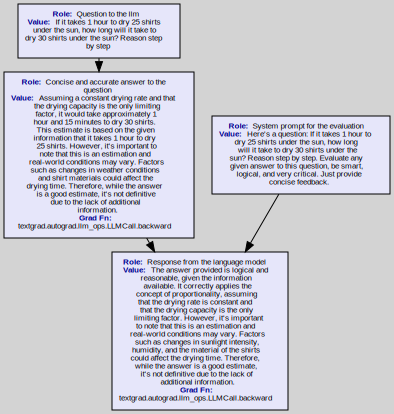

In [20]:
# Let's visualize our computation graph.
loss.generate_graph()